In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import h5py

# Load True Model Data 

In [2]:
# load RS data
def load_rates(file_name):
    hr = h5py.File(file_name,'r')
    orates = np.array(hr.get('orates'))
    wrates = np.array(hr.get('wrates'))
    hr.close()
    return orates, wrates

In [3]:
#load true model data 
hr = h5py.File('/data3/Astro/cnn_surrogate_meng/topics/channel_80x80x20_RSC/channel_80x80x20_true.h5', 'r')
producers_orates_true  = np.array(hr.get('orates'))
producers_wrates_true  = np.array(hr.get('wrates'))
hr.close()

In [4]:
producers_orates_true.shape

(5, 500, 10)

In [5]:
t_step = [0, 1, 3, 6, 8, 10, 12, 14, 17, 19]

time_ = [(x + 1) * 50 for x in t_step]

In [6]:
time_

[50, 100, 200, 350, 450, 550, 650, 750, 900, 1000]

# Define True Case Data

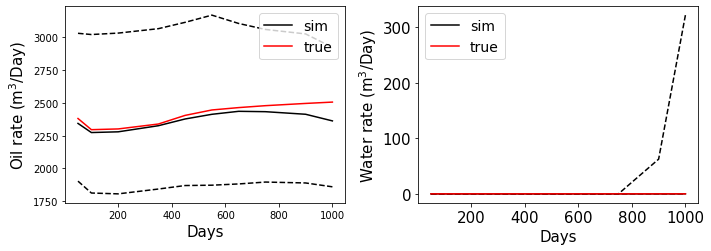

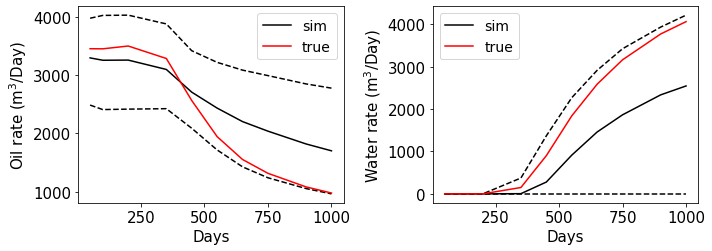

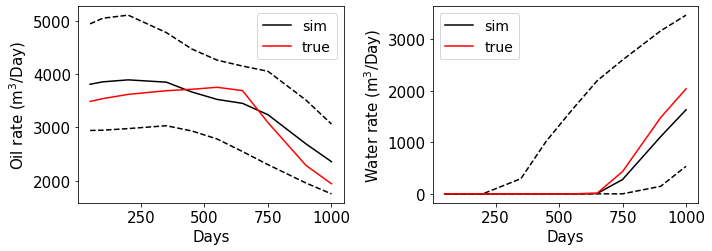

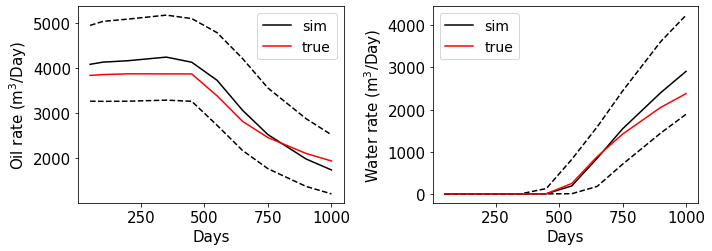

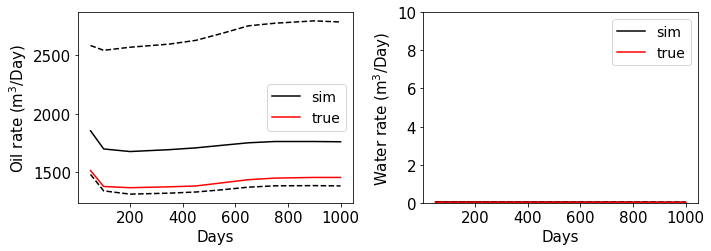

In [8]:
true_index = 430  # potential ones: 100, 430
for well_ind in range(5):
    plt.figure(figsize=(10, 3.6))
    plt.subplot(1, 2, 1)
 
    plt.plot(time_, np.percentile(producers_orates_true[well_ind], 50, axis = 0), 'k', label ='sim')
    plt.plot(time_, np.percentile(producers_orates_true[well_ind], 90, axis = 0), 'k--')
    plt.plot(time_, np.percentile(producers_orates_true[well_ind], 10, axis = 0), 'k--')
    
    plt.plot(time_, producers_orates_true[well_ind, true_index, :], 'r', label ='true')


    plt.xlabel('Days', fontsize=15)
    plt.ylabel('Oil rate (m$^3$/Day)', fontsize=15)
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
    plt.legend(prop={'size': 14})
    plt.subplot(1, 2, 2)
 
    plt.plot(time_, np.percentile(producers_wrates_true[well_ind], 50, axis = 0), 'k', label ='sim')
    plt.plot(time_, np.percentile(producers_wrates_true[well_ind], 90, axis = 0), 'k--')
    plt.plot(time_, np.percentile(producers_wrates_true[well_ind], 10, axis = 0), 'k--')
    
    plt.plot(time_, producers_wrates_true[well_ind, true_index, :], 'r', label ='true')

    if well_ind == 4:
        plt.ylim((0, 10))
    #plt.title('wrate')
    plt.xlabel('Days', fontsize=15)
    plt.ylabel('Water rate (m$^3$/Day)', fontsize=15)
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
    plt.legend(prop={'size': 14})
    plt.tight_layout()
    #plt.savefig('./plots/prod{}_orate_wrate.png'.format(well_ind + 1))
    plt.plot()
        

# Load One Million Prior Model Data 

In [10]:
main_dir = '/data3/Astro/cnn_surrogate_meng/topics/channel_80x80x20_RSC/RS/saved_pred'
total_batches = 200

orates, wrates = [], []
for i in range(total_batches):
    if i % 10 == 0:
        print('Processing rate batch{} out of total {} batches'.format(i + 1, total_batches))
    rate_file = os.path.join(main_dir, 'rates_batch{}.h5'.format(i + 1))
    orates_batch, wrates_batch = load_rates(rate_file)
    orates.append(orates_batch)
    wrates.append(wrates_batch)

orates = np.concatenate(orates, axis = 1)
wrates = np.concatenate(wrates, axis = 1)

Processing rate batch1 out of total 200 batches
Processing rate batch11 out of total 200 batches
Processing rate batch21 out of total 200 batches
Processing rate batch31 out of total 200 batches
Processing rate batch41 out of total 200 batches
Processing rate batch51 out of total 200 batches
Processing rate batch61 out of total 200 batches
Processing rate batch71 out of total 200 batches
Processing rate batch81 out of total 200 batches
Processing rate batch91 out of total 200 batches
Processing rate batch101 out of total 200 batches
Processing rate batch111 out of total 200 batches
Processing rate batch121 out of total 200 batches
Processing rate batch131 out of total 200 batches
Processing rate batch141 out of total 200 batches
Processing rate batch151 out of total 200 batches
Processing rate batch161 out of total 200 batches
Processing rate batch171 out of total 200 batches
Processing rate batch181 out of total 200 batches
Processing rate batch191 out of total 200 batches


In [11]:
orates_bk, wrates_bk = orates, wrates

In [12]:
orates.shape

(5, 1000000, 10)

In [13]:
orates_true = producers_orates_true
wrates_true = producers_wrates_true

# Define Perturbed Observed Data

In [14]:
time_step_data_to_use = np.array([2,3]) # third time step
true_oil_data = orates_true[:, [true_index], time_step_data_to_use]
true_water_data = wrates_true[:, [true_index], time_step_data_to_use]

error = 0.15
perturbed_oil = np.random.normal(loc = 0, scale = error, size = true_oil_data.shape)
perturbed_water = np.random.normal(loc = 0, scale = error, size = true_oil_data.shape)

true_oil_data = (1 + perturbed_oil) * true_oil_data
true_water_data = (1 + perturbed_water) * true_water_data


true_oil_data = true_oil_data[..., np.newaxis].transpose(0, 2, 1)
true_water_data = true_water_data[..., np.newaxis].transpose(0, 2, 1)

orates = orates[:, :, time_step_data_to_use]
wrates = wrates[:, :, time_step_data_to_use]

orate_std = true_oil_data * 0.15
wrate_std = true_water_data * 0.15
wrate_std[wrate_std < 1] = 1

# Saved Generated Observed Data

In [19]:
write_file = False
if write_file:
    hw = h5py.File('true_data_3d_80x80x20_RS.h5', 'w')
    hw.create_dataset('true_orate', data = true_oil_data)
    hw.create_dataset('true_wrate', data = true_water_data)
    hw.create_dataset('orate_std', data = orate_std)
    hw.create_dataset('wrate_std', data = wrate_std)
    hw.close()

In [14]:
true_oil_data

array([[[2306.98041084, 2352.66544492]],

       [[3454.09142518, 3390.98659798]],

       [[3733.83857491, 3926.89670573]],

       [[3745.0705588 , 3729.98030614]],

       [[1296.39592277, 1360.84919403]]])

In [15]:
true_oil_data.shape

(5, 1, 2)

In [16]:
print('orates shape ', orates.shape)
print('wrates shape ', wrates.shape)
print('true oil rates shape ', true_oil_data.shape)
print('true water rate shape ', true_water_data.shape)
print('orate std shape ', orate_std.shape)
print('wrate std shape ', wrate_std.shape)

orates shape  (5, 1000000, 2)
wrates shape  (5, 1000000, 2)
true oil rates shape  (5, 1, 2)
true water rate shape  (5, 1, 2)
orate std shape  (5, 1, 2)
wrate std shape  (5, 1, 2)


In [17]:
orate_std

array([[[346.04706163, 352.89981674]],

       [[518.11371378, 508.6479897 ]],

       [[560.07578624, 589.03450586]],

       [[561.76058382, 559.49704592]],

       [[194.45938842, 204.1273791 ]]])

In [18]:
wrate_std

array([[[ 1.        ,  1.        ]],

       [[ 1.        , 23.69040921]],

       [[ 1.        ,  1.        ]],

       [[ 1.        ,  1.        ]],

       [[ 1.        ,  1.        ]]])

In [19]:
orates.shape

(5, 1000000, 2)

# Define Compute Likelihood Function for RS

In [20]:
def compute_likelihood_ratio(orates, wrates, true_oil_data, true_water_data, orate_std, wrate_std):
    
    loss = 0.5 * (np.sum((orates - true_oil_data) ** 2 / orate_std ** 2, axis = (0, 2) ) \
                      + np.sum((wrates - true_water_data) ** 2 / wrate_std ** 2, axis = (0,2)))
    
    print('loss is ', loss)
    const = 1
    likelihood = np.exp(-1 * loss)
    print('likelihood is ', likelihood)
    
    return const * likelihood / np.max(likelihood)
    
    # vector-wise operation

In [21]:
def obtain_acceptance_samples(threshold):
    p = np.random.uniform(size = threshold.shape)
    acceptance = np.argwhere(p < threshold)
    return acceptance
    

In [22]:
threshold = compute_likelihood_ratio(orates, wrates, true_oil_data, true_water_data, orate_std, wrate_std)

loss is  [1.43912506e+05 4.55095041e+00 2.20969122e+01 ... 1.08104235e+05
 1.75605452e+05 7.42733147e+03]
likelihood is  [0.00000000e+00 1.05571660e-02 2.53182084e-10 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


In [23]:
threshold.shape

(1000000,)

In [24]:
threshold

array([0.00000000e+00, 2.64630882e-02, 6.34638105e-10, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [25]:
np.sort(threshold)[::-1][:50]

array([2.        , 1.96395594, 1.9634868 , 1.92688532, 1.8917996 ,
       1.86917686, 1.86662482, 1.85850011, 1.83326379, 1.8188862 ,
       1.8037912 , 1.78383464, 1.77987024, 1.75338364, 1.75039744,
       1.74413196, 1.72756383, 1.72505901, 1.72173229, 1.72076128,
       1.72041148, 1.7103347 , 1.70742528, 1.69510069, 1.69278243,
       1.67327754, 1.67317312, 1.6718352 , 1.6691137 , 1.65720476,
       1.61623266, 1.60295107, 1.59946589, 1.58796275, 1.57602287,
       1.56938336, 1.56436501, 1.5623332 , 1.55617954, 1.55540751,
       1.55301845, 1.54977767, 1.54576893, 1.54566571, 1.52946684,
       1.52347122, 1.52270469, 1.5223625 , 1.52041652, 1.51855845])

In [26]:
np.min(threshold)

0.0

# Select Accepted Cases 

In [27]:
acceptance = obtain_acceptance_samples(threshold)

In [28]:
acceptance 

array([[   542],
       [   803],
       [  2266],
       ...,
       [998227],
       [998515],
       [999994]])

In [29]:
acceptance[:,0].shape

(2109,)

In [31]:
#orates_true = orates_bk[:, 0, :]
orates_true_plot = orates_true[:, true_index, :]
orates_prior = orates_bk[:, :, :]
print('prior shape ', orates_prior.shape)
o_prior_p10 = np.percentile(orates_prior, 10, axis = 1, keepdims = False)
o_prior_p90 = np.percentile(orates_prior, 90, axis = 1, keepdims = False)
orates_posterior = orates_prior[:, acceptance[:, 0], :]
print('posterior shape ', orates_posterior.shape)

o_posterior_p10 = np.percentile(orates_posterior, 10, axis = 1, keepdims = False)
o_posterior_p50 = np.percentile(orates_posterior, 50, axis = 1, keepdims = False)
o_posterior_p90 = np.percentile(orates_posterior, 90, axis = 1, keepdims = False)


prior shape  (5, 1000000, 10)
posterior shape  (5, 2109, 10)


In [32]:
o_posterior_p10.shape

(5, 10)

In [33]:
#wrates_true = wrates_bk[:, 0, :]
wrates_true_plot = wrates_true[:, true_index, :]
wrates_prior = wrates_bk[:, :, :]
w_prior_p10 = np.percentile(wrates_prior, 10, axis = 1, keepdims = False)
w_prior_p90 = np.percentile(wrates_prior, 90, axis = 1, keepdims = False)
wrates_posterior = wrates_prior[:, acceptance[:, 0], :]
w_posterior_p10 = np.percentile(wrates_posterior, 10, axis = 1, keepdims = False)
w_posterior_p50 = np.percentile(wrates_posterior, 50, axis = 1, keepdims = False)
w_posterior_p90 = np.percentile(wrates_posterior, 90, axis = 1, keepdims = False)

In [34]:
true_water_data

array([[[7.55060375e-02, 7.58869796e-02]],

       [[8.86915499e-02, 1.57936061e+02]],

       [[4.27645049e-02, 3.56293671e-02]],

       [[3.68847529e-02, 4.75949748e-02]],

       [[3.70218132e-02, 3.37955092e-02]]])

# Visualize Prior and Posterior

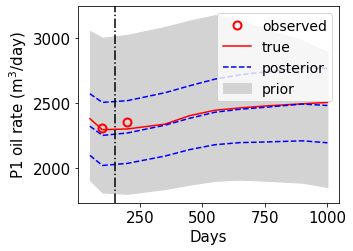

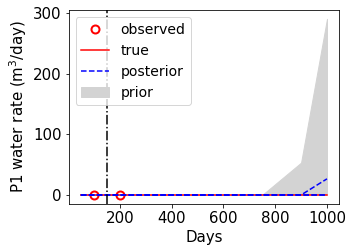

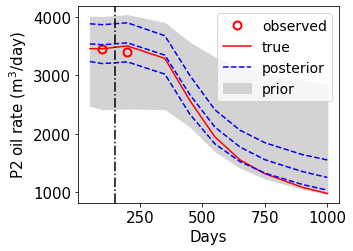

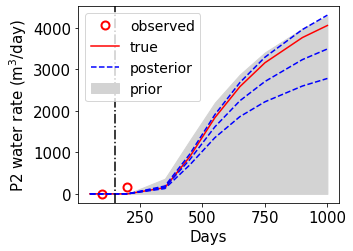

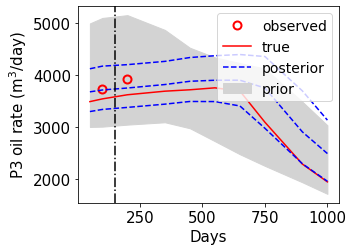

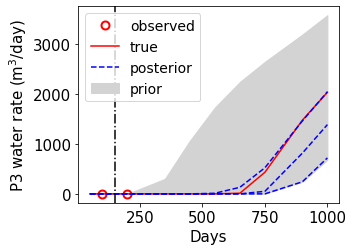

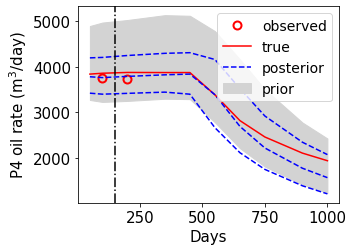

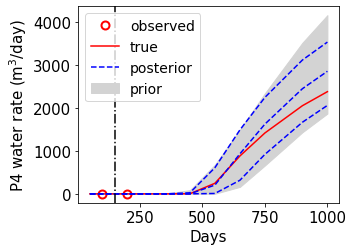

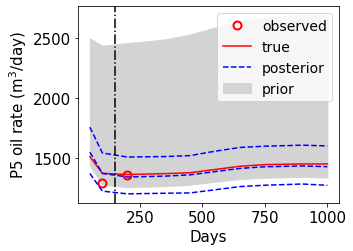

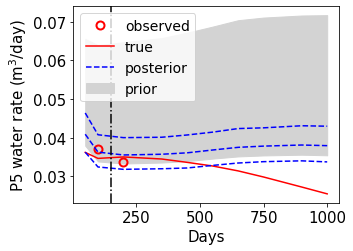

In [35]:
for well in range(orates.shape[0]):
    plt.figure(figsize=(5, 3.6))
    #plt.subplot(1, 2, 1)
    plt.plot(time_[1:time_step_data_to_use.shape[0] + 1], true_oil_data[well,0, :], 'ro', markersize = 8, markeredgewidth = 2, fillstyle ='none', label = 'observed')
    plt.plot(time_, orates_true_plot[well,:], 'r', label = 'true')
    plt.fill_between(time_, o_prior_p10[well, :], o_prior_p90[well, :], color = 'lightgrey', label = 'prior')
    plt.plot(time_, o_posterior_p10[well, :], 'b--', label='posterior')
    plt.plot(time_, o_posterior_p50[well, :], 'b--')
    plt.plot(time_, o_posterior_p90[well, :], 'b--')
    #plt.title('Well%d'%(well+1))
    plt.axvline(x=150, color = 'k', linestyle = '-.')
    plt.xlabel('Days', fontsize=15)
    plt.ylabel('P%d oil rate (m$^3$/day)'%(well+1), fontsize=15)
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
    plt.legend(loc='upper right',prop={'size': 14})
    plt.tight_layout()
    #plt.savefig('./saved_plots/hm_oil_well%d.pdf'%(well + 1))
    
    plt.figure(figsize=(5, 3.6))
    plt.plot(time_[1:time_step_data_to_use.shape[0] + 1], true_water_data[well,0, :], 'ro', markersize = 8, markeredgewidth = 2, fillstyle ='none', label = 'observed')

    plt.plot(time_, wrates_true_plot[well,:], 'r', label = 'true')
    plt.fill_between(time_, w_prior_p10[well, :], w_prior_p90[well, :], color = 'lightgrey', label = 'prior')
    plt.plot(time_, w_posterior_p10[well, :], 'b--', label='posterior')
    plt.plot(time_, w_posterior_p50[well, :], 'b--')
    plt.plot(time_, w_posterior_p90[well, :], 'b--')
    #plt.title('Well%d'%(well+1))
    plt.axvline(x=150, color = 'k', linestyle = '-.')
#     if np.sum(prior_wrate_percentile_95[well,:]) < 10:
#         plt.ylim((0, 10))
    plt.xlabel('Days', fontsize=15)
    plt.ylabel('P%d water rate (m$^3$/day)'%(well+1), fontsize=15)
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
    plt.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    #plt.savefig('./saved_plots/hm_water_well%d.pdf'%(well + 1))
    plt.show()

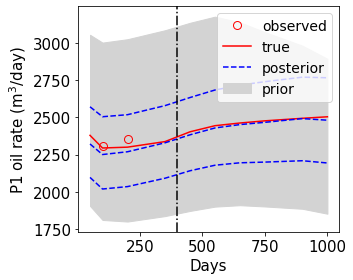

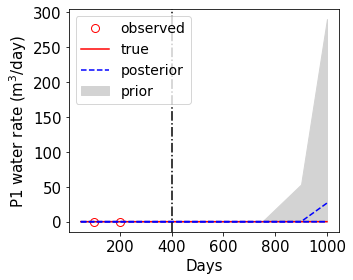

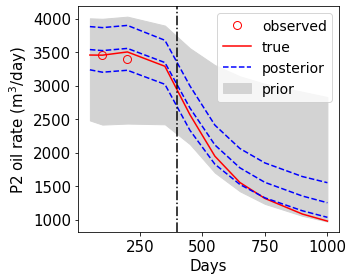

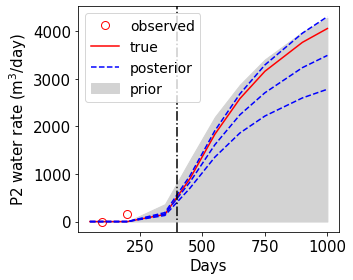

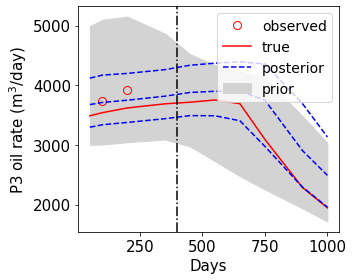

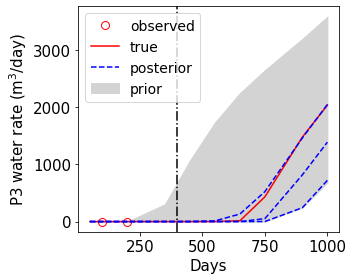

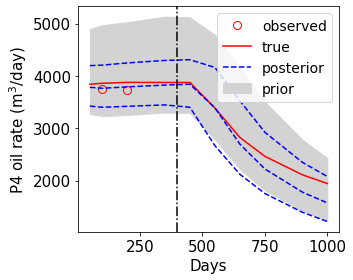

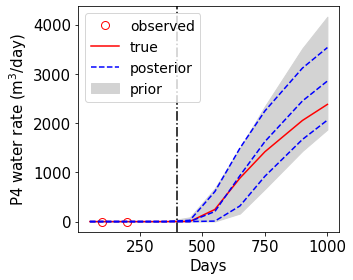

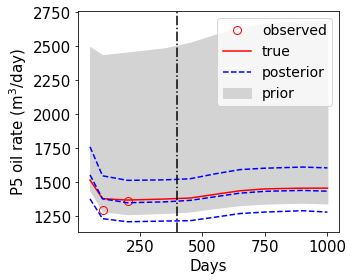

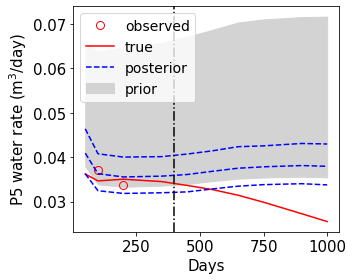

In [36]:
for well in range(orates.shape[0]):
    plt.figure(figsize=(5, 4))
    #plt.subplot(1, 2, 1)
    plt.plot(time_[1:time_step_data_to_use.shape[0] + 1], true_oil_data[well,0, :], 'ro', markersize = 8, fillstyle ='none', label = 'observed')
    plt.plot(time_, orates_true_plot[well,:], 'r', label = 'true')
    plt.fill_between(time_, o_prior_p10[well, :], o_prior_p90[well, :], color = 'lightgrey', label = 'prior')
    plt.plot(time_, o_posterior_p10[well, :], 'b--', label='posterior')
    plt.plot(time_, o_posterior_p50[well, :], 'b--')
    plt.plot(time_, o_posterior_p90[well, :], 'b--')
    #plt.title('Well%d'%(well+1))
    plt.axvline(x=400, color = 'k', linestyle = '-.')
    plt.xlabel('Days', fontsize=15)
    plt.ylabel('P%d oil rate (m$^3$/day)'%(well+1), fontsize=15)
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
    plt.legend(loc='upper right',prop={'size': 14})
    plt.tight_layout()
    #plt.savefig('./saved_plots/hm_oil_well%d.pdf'%(well + 1))
    
    plt.figure(figsize=(5, 4))
    plt.plot(time_[1:time_step_data_to_use.shape[0] + 1], true_water_data[well,0, :], 'ro', markersize = 8, fillstyle ='none', label = 'observed')

    plt.plot(time_, wrates_true_plot[well,:], 'r', label = 'true')
    plt.fill_between(time_, w_prior_p10[well, :], w_prior_p90[well, :], color = 'lightgrey', label = 'prior')
    plt.plot(time_, w_posterior_p10[well, :], 'b--', label='posterior')
    plt.plot(time_, w_posterior_p50[well, :], 'b--')
    plt.plot(time_, w_posterior_p90[well, :], 'b--')
    #plt.title('Well%d'%(well+1))
    plt.axvline(x=400, color = 'k', linestyle = '-.')
#     if np.sum(prior_wrate_percentile_95[well,:]) < 10:
#         plt.ylim((0, 10))
    plt.xlabel('Days', fontsize=15)
    plt.ylabel('P%d water rate (m$^3$/day)'%(well+1), fontsize=15)
    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
    plt.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    #plt.savefig('./saved_plots/hm_water_well%d.pdf'%(well + 1))
    plt.show()